In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.time_frequency import tfr_multitaper
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from mne.preprocessing import ICA 
from mne_icalabel import label_components
from autoreject import AutoReject
%matplotlib qt

In [2]:
# 처리할 사용자와 세션 리스트
names = ['cho', 'taek', 'choi', 'jung', 'song']  # 여러 명이면 ['choi', 'kim', ...]
sessions = ['1', '2', '3']  # 여러 세션이면 ['1', '2', ...]

# 결과 저장용
all_results = []
all_ratio_results = []  # alpha/theta 비율 저장용

for name in names:
    for session in sessions:
        edf_path = Path(f'./EEG_nback_task/{name}_nback_{session}.edf')
        marker_path = Path(f'./EEG_nback_task/{name}_nback_{session}_intervalMarker.csv')
        if not edf_path.exists() or not marker_path.exists():
            print(f"파일 없음: {edf_path} 또는 {marker_path}")
            continue

        print(f"처리 중: {edf_path.name}")

        # 1. EDF 파일 로드
        raw = mne.io.read_raw_edf(str(edf_path), preload=True)
        

        # 2. 채널 설정 등 전처리 
        eeg_channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
        raw.pick_channels(eeg_channels)
        montage = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(montage, match_case=False)

        
        raw.filter(l_freq=1, h_freq=40)
        raw.notch_filter(freqs=60)
        raw.set_eeg_reference('average')

        # epochs 생성 
        events = mne.make_fixed_length_events(raw, duration=3.0)
        epochs = mne.Epochs(
            raw, events,
            tmin=0, tmax=3.0-1/raw.info['sfreq'],
            baseline=None,
            preload=True
        )

        # AutoReject으로 bad channel과 bad epoch 동시 처리
        ar = AutoReject(random_state=42)
        epochs_clean = ar.fit_transform(epochs)

        ica = ICA(n_components=None, random_state=42)
        ica.fit(raw)

        # ICA 성분 자동 분류
        ic_labels = label_components(raw, ica, method='iclabel')

        # 뇌파가 아닌 성분들 자동 제거
        labels = ic_labels['labels']
        exclude_idx = [idx for idx, label in enumerate(labels) 
                       if label in ['eye blink', 'muscle artifact', 'heart beat']]

        ica.exclude = exclude_idx
        ica.apply(raw)
        print(f"자동 제거될 성분: {exclude_idx}")

        # 3. 마커 파일 로드 및 세그먼트 분할
        def load_and_segment_nback_data(raw, marker_file):
            markers_df = pd.read_csv(marker_file)

            task_starts = markers_df[markers_df['type'] == 'task_start']['latency'].values
            task_ends = markers_df[markers_df['type'] == 'task__end']['latency'].values

            segments = {'0back': None, 'rest': [], '2back': None, '3back': None}
            zero_back_end_idx = np.where(task_starts < task_ends[0])[0][-1]
            segments['0back'] = raw.copy().crop(tmin=task_starts[0], tmax=task_ends[0])

            rest_start = task_ends[0]
            rest_end = task_starts[zero_back_end_idx + 1]
            segments['rest'].append(raw.copy().crop(tmin=rest_start, tmax=rest_end))
            two_back_end_idx = np.where(task_starts < task_ends[1])[0][-1]
            segments['2back'] = raw.copy().crop(tmin=task_starts[zero_back_end_idx + 1], tmax=task_ends[1])

            rest_start = task_ends[1]
            rest_end = task_starts[two_back_end_idx + 1]
            segments['rest'].append(raw.copy().crop(tmin=rest_start, tmax=rest_end))
            three_back_end_idx = np.where(task_starts < task_ends[2])[0][-1]
            segments['3back'] = raw.copy().crop(tmin=task_starts[two_back_end_idx + 1], tmax=task_ends[2])
            rest_start = task_ends[2]

            if len(task_starts) > three_back_end_idx + 1:
                rest_end = task_starts[three_back_end_idx + 1]
            else:
                rest_end = raw.times[-1]
            segments['rest'].append(raw.copy().crop(tmin=rest_start, tmax=rest_end))

            return segments

        segments = load_and_segment_nback_data(raw, marker_path)

        # 4. ERDS 계산 (예시: theta, alpha 밴드)
        def calculate_erds_with_psd(task_raw, rest_raw, fmin, fmax, channels):
            task_data = task_raw.copy().pick(channels)
            rest_data = rest_raw.copy().pick(channels)
            task_psd = task_data.compute_psd(fmin=fmin, fmax=fmax, n_fft=1024, n_overlap=512)
            rest_psd = rest_data.compute_psd(fmin=fmin, fmax=fmax, n_fft=1024, n_overlap=512)
            freq_mask = (task_psd.freqs >= fmin) & (task_psd.freqs <= fmax)
            task_power = task_psd.get_data()[:, freq_mask].mean(axis=1)
            rest_power = rest_psd.get_data()[:, freq_mask].mean(axis=1)
            erds = (rest_power - task_power) / rest_power * 100
            return erds

        # 5. 수정된 Alpha/Theta 비율 계산 함수
        def calculate_region_specific_alpha_theta_ratio(raw_data, theta_channels, alpha_channels):
            """
            특정 영역별 채널들에서 alpha/theta 비율 계산
            theta_channels: 전두엽 채널들 (AF3, AF4, F3, F4, F7, F8)
            alpha_channels: 두정엽 채널들 (P7, P8)
            """
            # Theta 파워 계산 (전두엽 채널들에서)
            theta_data = raw_data.copy().pick(theta_channels)
            theta_psd = theta_data.compute_psd(fmin=4, fmax=7, n_fft=1024, n_overlap=512)
            theta_mask = (theta_psd.freqs >= 4) & (theta_psd.freqs <= 7)
            theta_power_per_channel = theta_psd.get_data()[:, theta_mask].mean(axis=1)
            # 전두엽 채널들의 평균 theta 파워
            theta_power = np.mean(theta_power_per_channel)
            
            # Alpha 파워 계산 (두정엽 채널들에서)
            alpha_data = raw_data.copy().pick(alpha_channels)
            alpha_psd = alpha_data.compute_psd(fmin=8, fmax=13, n_fft=1024, n_overlap=512)
            alpha_mask = (alpha_psd.freqs >= 8) & (alpha_psd.freqs <= 13)
            alpha_power_per_channel = alpha_psd.get_data()[:, alpha_mask].mean(axis=1)
            # 두정엽 채널들의 평균 alpha 파워
            alpha_power = np.mean(alpha_power_per_channel)
            
            # Alpha/Theta 비율 계산
            ratio = alpha_power / theta_power
            return ratio, alpha_power, theta_power

        freq_bands = {'theta': (4, 7), 'alpha': (8, 13)}
        channel_groups = {'theta': ['F3', 'F4'], 'alpha': ['P7', 'P8']}
        
        # Alpha/Theta 비율 계산을 위한 채널 그룹 정의
        theta_channels = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8']  # 전두엽
        alpha_channels = ['P7', 'P8']  # 두정엽
        
        conditions = [
            ('0back', 0), ('2back', 1), ('3back', 2)
        ]

        # rest1만 기준으로 ERDS 계산
        rest1 = segments['rest'][0]  # 첫 번째 rest 구간만 사용

        # ERDS 계산 (기존 코드)
        for band, (fmin, fmax) in freq_bands.items():
            for cond in ['0back', '2back', '3back']:
                if segments[cond] is not None and rest1 is not None:
                    erds = calculate_erds_with_psd(
                        segments[cond], rest1, fmin, fmax, channel_groups[band]
                    )
                    for ch, val in zip(channel_groups[band], erds):
                        all_results.append({
                            'name': name,
                            'session': session,
                            'condition': cond,
                            'band': band,
                            'channel': ch,
                            'erds': val
                        })

        # 수정된 Alpha/Theta 비율 계산
        # Baseline (rest) 비율 계산
        if rest1 is not None:
            rest_ratio, rest_alpha, rest_theta = calculate_region_specific_alpha_theta_ratio(
                rest1, theta_channels, alpha_channels
            )
            all_ratio_results.append({
                'name': name,
                'session': session,
                'condition': 'rest',
                'alpha_theta_ratio': rest_ratio,
                'alpha_power': rest_alpha,
                'theta_power': rest_theta,
                'theta_region': 'frontal',  # AF3, AF4, F3, F4, F7, F8
                'alpha_region': 'parietal'  # P7, P8
            })

        # Task 조건별 비율 계산
        for cond in ['0back', '2back', '3back']:
            if segments[cond] is not None:
                task_ratio, task_alpha, task_theta = calculate_region_specific_alpha_theta_ratio(
                    segments[cond], theta_channels, alpha_channels
                )
                all_ratio_results.append({
                    'name': name,
                    'session': session,
                    'condition': cond,
                    'alpha_theta_ratio': task_ratio,
                    'alpha_power': task_alpha,
                    'theta_power': task_theta,
                    'theta_region': 'frontal',  # AF3, AF4, F3, F4, F7, F8
                    'alpha_region': 'parietal'  # P7, P8
                })

# 결과를 데이터프레임으로 저장
df = pd.DataFrame(all_results)
df_ratio = pd.DataFrame(all_ratio_results)

df.to_csv('all_subjects_erds_results.csv', index=False)
df_ratio.to_csv('all_subjects_region_specific_alpha_theta_ratio_results.csv', index=False)

print("모든 사용자/세션에 대한 ERDS 결과가 all_subjects_erds_results.csv에 저장되었습니다.")
print("모든 사용자/세션에 대한 영역별 Alpha/Theta 비율 결과가 all_subjects_region_specific_alpha_theta_ratio_results.csv에 저장되었습니다.")

# 세션별 평균 계산 및 그래프 그리기
conditions_list = ['0back', '2back', '3back']
ratio_conditions_list = ['rest', '0back', '2back', '3back']
bands = ['theta', 'alpha']
channels_dict = {'theta': ['F3', 'F4'], 'alpha': ['P7', 'P8']}

# 그래프 저장을 위한 디렉토리 생성 (선택사항)
import os
os.makedirs('plots', exist_ok=True)

# 1. 기존 ERDS 그래프
for name in df['name'].unique():
    user_df = df[df['name'] == name]
    
    for band in bands:
        plt.figure(figsize=(10, 6))
        
        for ch in channels_dict[band]:
            y_values = []
            std_values = []
            
            for cond in conditions_list:
                session_values = user_df[
                    (user_df['band'] == band) & 
                    (user_df['channel'] == ch) & 
                    (user_df['condition'] == cond)
                ]['erds'].values
                
                if len(session_values) > 0:
                    mean_val = np.mean(session_values)
                    std_val = np.std(session_values)
                    y_values.append(mean_val)
                    std_values.append(std_val)
                else:
                    y_values.append(np.nan)
                    std_values.append(0)
            
            plt.errorbar(conditions_list, y_values, yerr=std_values, 
                        marker='o', linewidth=2, markersize=8, 
                        capsize=5, capthick=2, label=f'{ch} (n={len(sessions)})')
        
        plt.title(f"{name} - {band.capitalize()} Band ERDS (Session Average)", 
                 fontsize=14, fontweight='bold')
        plt.xlabel("Condition", fontsize=12)
        plt.ylabel("ERDS (%)", fontsize=12)
        plt.ylim(-100, 100)
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        filename = f"plots/{name}_{band}_erds_session_average.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"그래프 저장됨: {filename}")
        
        plt.show()

# 2. 수정된 Alpha/Theta 비율 그래프 (영역별)
for name in df_ratio['name'].unique():
    user_ratio_df = df_ratio[df_ratio['name'] == name]
    
    plt.figure(figsize=(10, 6))
    
    y_values = []
    std_values = []
    
    for cond in ratio_conditions_list:
        session_values = user_ratio_df[
            user_ratio_df['condition'] == cond
        ]['alpha_theta_ratio'].values
        
        if len(session_values) > 0:
            mean_val = np.mean(session_values)
            std_val = np.std(session_values)
            y_values.append(mean_val)
            std_values.append(std_val)
        else:
            y_values.append(np.nan)
            std_values.append(0)
    
    plt.errorbar(ratio_conditions_list, y_values, yerr=std_values, 
                marker='o', linewidth=3, markersize=10, 
                capsize=8, capthick=3, color='purple')
    
    plt.title(f"{name} - Alpha(P7,P8)/Theta(AF3,AF4,F3,F4,F7,F8) Ratio", 
             fontsize=14, fontweight='bold')
    plt.xlabel("Condition", fontsize=12)
    plt.ylabel("Alpha/Theta Ratio", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    filename = f"plots/{name}_region_specific_alpha_theta_ratio.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"영역별 Alpha/Theta 비율 그래프 저장됨: {filename}")
    
    plt.show()

# 3. 모든 사용자의 Alpha/Theta 비율 비교 그래프
plt.figure(figsize=(12, 8))

for name in df_ratio['name'].unique():
    user_ratio_df = df_ratio[df_ratio['name'] == name]
    
    y_values = []
    
    for cond in ratio_conditions_list:
        session_values = user_ratio_df[
            user_ratio_df['condition'] == cond
        ]['alpha_theta_ratio'].values
        
        if len(session_values) > 0:
            mean_val = np.mean(session_values)
            y_values.append(mean_val)
        else:
            y_values.append(np.nan)
    
    plt.plot(ratio_conditions_list, y_values, 
             marker='o', linewidth=2, markersize=8, 
             label=name)

plt.title("All Subjects - Alpha(P7,P8)/Theta(AF3,AF4,F3,F4,F7,F8) Ratio Comparison", 
         fontsize=16, fontweight='bold')
plt.xlabel("Condition", fontsize=12)
plt.ylabel("Alpha/Theta Ratio", fontsize=12)
plt.xticks(rotation=45)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

filename = "plots/all_subjects_region_specific_alpha_theta_ratio_comparison.png"
plt.savefig(filename, dpi=300, bbox_inches='tight')
print(f"전체 사용자 비교 그래프 저장됨: {filename}")
plt.show()

# 세션별 상세 데이터 요약 출력
print("\n=== 세션별 ERDS 요약 ===")
for name in df['name'].unique():
    print(f"\n사용자: {name}")
    user_df = df[df['name'] == name]
    
    for band in bands:
        print(f"\n  {band.capitalize()} Band:")
        for ch in channels_dict[band]:
            print(f"    {ch}:")
            for cond in conditions_list:
                session_values = user_df[
                    (user_df['band'] == band) & 
                    (user_df['channel'] == ch) & 
                    (user_df['condition'] == cond)
                ]['erds'].values
                
                if len(session_values) > 0:
                    mean_val = np.mean(session_values)
                    std_val = np.std(session_values)
                    print(f"      {cond}: {mean_val:.2f} ± {std_val:.2f} % (n={len(session_values)})")
                else:
                    print(f"      {cond}: 데이터 없음")

# 영역별 Alpha/Theta 비율 요약 출력
print("\n=== 영역별 Alpha/Theta 비율 요약 ===")
print("Theta: 전두엽 (AF3, AF4, F3, F4, F7, F8)")
print("Alpha: 두정엽 (P7, P8)")

for name in df_ratio['name'].unique():
    print(f"\n사용자: {name}")
    user_ratio_df = df_ratio[df_ratio['name'] == name]
    
    for cond in ratio_conditions_list:
        session_values = user_ratio_df[
            user_ratio_df['condition'] == cond
        ]['alpha_theta_ratio'].values
        
        alpha_values = user_ratio_df[
            user_ratio_df['condition'] == cond
        ]['alpha_power'].values
        
        theta_values = user_ratio_df[
            user_ratio_df['condition'] == cond
        ]['theta_power'].values
        
        if len(session_values) > 0:
            ratio_mean = np.mean(session_values)
            ratio_std = np.std(session_values)
            alpha_mean = np.mean(alpha_values)
            theta_mean = np.mean(theta_values)
            print(f"  {cond}: ")
            print(f"    Alpha/Theta 비율: {ratio_mean:.3f} ± {ratio_std:.3f}")
            print(f"    Alpha 파워 (P7,P8): {alpha_mean:.6f}")
            print(f"    Theta 파워 (전두엽): {theta_mean:.6f}")
            print(f"    세션 수: {len(session_values)}")
        else:
            print(f"  {cond}: 데이터 없음")

처리 중: cho_nback_1.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\cho_nback_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 29695  =      0.000 ...   231.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/77 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/77 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/77 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/77 [00:00<?,       ?it/s]

c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/77 [00:00<?,       ?it/s]

Dropped 52 epochs: 5, 6, 7, 8, 9, 10, 12, 15, 28, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 72, 73, 74, 75, 76
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.3s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 4 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [0, 1, 3, 12]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: cho_nback_2.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\cho_nback_2.edf...
E

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/67 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/67 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/67 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/67 [00:00<?,       ?it/s]

c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=1.00 and n_interpolate=13


  0%|          | Repairing epochs : 0/67 [00:00<?,       ?it/s]

Dropped 1 epoch: 18
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.2s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [0, 1, 2]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: cho_nback_3.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\cho_nback_3.edf...
EDF f

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=1.00 and n_interpolate=13


  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

Dropped 1 epoch: 16
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.1s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [0, 1, 9]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: taek_nback_1.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\taek_nback_1.edf...
EDF

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=1.00 and n_interpolate=13


  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.1s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [0, 2, 9]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: taek_nback_2.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\taek_nback_2.edf...
EDF

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=4


  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.1s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [0, 3, 11]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: taek_nback_3.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\taek_nback_3.edf...
ED

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=1


  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.1s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [0, 2, 11]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: choi_nback_1.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\choi_nback_1.edf...
ED

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/74 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/74 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/74 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/74 [00:00<?,       ?it/s]

c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=1.00 and n_interpolate=13


  0%|          | Repairing epochs : 0/74 [00:00<?,       ?it/s]

Dropped 2 epochs: 26, 73
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.1s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 5 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [2, 3, 4, 5, 6]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: choi_nback_2.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\choi_nback_2.edf.

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.80 and n_interpolate=4


  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.2s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [0, 2, 3]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: choi_nback_3.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\choi_nback_3.edf...
EDF

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/68 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/68 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/68 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/68 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.80 and n_interpolate=4


  0%|          | Repairing epochs : 0/68 [00:00<?,       ?it/s]

Dropped 2 epochs: 4, 19
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.1s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 7 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [1, 2, 4, 5, 8, 9, 10]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: jung_nback_1.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\jung_nback

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

Dropped 14 epochs: 0, 1, 2, 22, 23, 24, 25, 26, 29, 43, 44, 62, 66, 67
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.2s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [1, 4, 5]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: jung_nback_2.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\jung_nback_2.edf...
EDF

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.80 and n_interpolate=4


  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

Dropped 3 epochs: 0, 37, 58
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.1s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 2 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [1, 4]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: jung_nback_3.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\jung_nback_3.edf...
EDF fi

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=4


  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

Dropped 9 epochs: 0, 5, 13, 37, 38, 42, 58, 59, 64
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.1s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [0, 3, 9]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: song_nback_1.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\song_nback_1.edf...
EDF

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/82 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/82 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/82 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/82 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=4


  0%|          | Repairing epochs : 0/82 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.1s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 2 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [0, 2]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: song_nback_2.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\song_nback_2.edf...
EDF fi

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=4


  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

Dropped 2 epochs: 10, 20
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.2s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [1, 2, 4]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: song_nback_3.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\song_nback_3.edf...
EDF

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=4


  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

Dropped 1 epoch: 21
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.2s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_41476\757284080.py:51: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 2 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [1, 3]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
모든 사용자/세션에 대한 ERDS 결과가 all_subjects_erds_results.csv에 저장되었습니다.
모든 사용자/세션에 대한 영역별 Alpha/Theta 비율 결과가 all_subjects_region_specific_alpha_theta_ratio_res

In [3]:
# 처리할 사용자와 세션 리스트
names = ['cho', 'taek', 'choi', 'jung', 'song']  # 여러 명이면 ['choi', 'kim', ...]
sessions = ['1', '2', '3']  # 여러 세션이면 ['1', '2', ...]

# 결과 저장용
all_results = []

for name in names:
    for session in sessions:
        edf_path = Path(f'./EEG_nback_task/{name}_nback_{session}.edf')
        marker_path = Path(f'./EEG_nback_task/{name}_nback_{session}_intervalMarker.csv')
        if not edf_path.exists() or not marker_path.exists():
            print(f"파일 없음: {edf_path} 또는 {marker_path}")
            continue

        print(f"처리 중: {edf_path.name}")

        # 1. EDF 파일 로드
        raw = mne.io.read_raw_edf(str(edf_path), preload=True)
        

        # 2. 채널 설정 등 전처리 
        eeg_channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
        raw.pick_channels(eeg_channels)
        montage = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(montage, match_case=False)


        
        raw.filter(l_freq=1, h_freq=40)
        raw.notch_filter(freqs=60)
        raw.set_eeg_reference('average')

        # epochs 생성 
        events = mne.make_fixed_length_events(raw, duration=3.0)
        epochs = mne.Epochs(
            raw, events,
            tmin=0, tmax=3.0-1/raw.info['sfreq'],
            baseline=None,
            preload=True
        )

        # AutoReject으로 bad channel과 bad epoch 동시 처리
        ar = AutoReject(random_state=42)
        epochs_clean = ar.fit_transform(epochs)

        ica = ICA(n_components=None, random_state=42)
        ica.fit(raw)

        # ica.plot_sources(raw)

        # ICA 성분 자동 분류
        ic_labels = label_components(raw, ica, method='iclabel')

        # 뇌파가 아닌 성분들 자동 제거
        labels = ic_labels['labels']
        exclude_idx = [idx for idx, label in enumerate(labels) 
                       if label in ['eye blink', 'muscle artifact', 'heart beat']]

        ica.exclude = exclude_idx
        ica.apply(raw)
        print(f"자동 제거될 성분: {exclude_idx}")

        # 3. 마커 파일 로드 및 세그먼트 분할
        def load_and_segment_nback_data(raw, marker_file):
            markers_df = pd.read_csv(marker_file)

            task_starts = markers_df[markers_df['type'] == 'task_start']['latency'].values
            task_ends = markers_df[markers_df['type'] == 'task__end']['latency'].values

            segments = {'0back': None, 'rest': [], '2back': None, '3back': None}
            zero_back_end_idx = np.where(task_starts < task_ends[0])[0][-1]
            segments['0back'] = raw.copy().crop(tmin=task_starts[0], tmax=task_ends[0])

            rest_start = task_ends[0]
            rest_end = task_starts[zero_back_end_idx + 1]
            segments['rest'].append(raw.copy().crop(tmin=rest_start, tmax=rest_end))
            two_back_end_idx = np.where(task_starts < task_ends[1])[0][-1]
            segments['2back'] = raw.copy().crop(tmin=task_starts[zero_back_end_idx + 1], tmax=task_ends[1])

            rest_start = task_ends[1]
            rest_end = task_starts[two_back_end_idx + 1]
            segments['rest'].append(raw.copy().crop(tmin=rest_start, tmax=rest_end))
            three_back_end_idx = np.where(task_starts < task_ends[2])[0][-1]
            segments['3back'] = raw.copy().crop(tmin=task_starts[two_back_end_idx + 1], tmax=task_ends[2])
            rest_start = task_ends[2]

            if len(task_starts) > three_back_end_idx + 1:
                rest_end = task_starts[three_back_end_idx + 1]
            else:
                rest_end = raw.times[-1]
            segments['rest'].append(raw.copy().crop(tmin=rest_start, tmax=rest_end))

            return segments

        segments = load_and_segment_nback_data(raw, marker_path)

        # 4. ERDS 계산 (예시: theta, alpha 밴드)
        def calculate_erds_with_psd(task_raw, rest_raw, fmin, fmax, channels):
            task_data = task_raw.copy().pick(channels)
            rest_data = rest_raw.copy().pick(channels)
            task_psd = task_data.compute_psd(fmin=fmin, fmax=fmax, n_fft=1024, n_overlap=512)
            rest_psd = rest_data.compute_psd(fmin=fmin, fmax=fmax, n_fft=1024, n_overlap=512)
            freq_mask = (task_psd.freqs >= fmin) & (task_psd.freqs <= fmax)
            task_power = task_psd.get_data()[:, freq_mask].mean(axis=1)
            rest_power = rest_psd.get_data()[:, freq_mask].mean(axis=1)
            erds = (rest_power - task_power) / rest_power * 100
            return erds

        freq_bands = {'theta': (4, 7), 'alpha': (8, 13)}
        channel_groups = {'theta': ['F3', 'F4'], 'alpha': ['P7', 'P8']}
        conditions = [
            ('0back', 0), ('2back', 1), ('3back', 2)
        ]

        # rest1만 기준으로 ERDS 계산
        rest1 = segments['rest'][0]  # 첫 번째 rest 구간만 사용

        for band, (fmin, fmax) in freq_bands.items():
            for cond in ['0back', '2back', '3back']:
                if segments[cond] is not None and rest1 is not None:
                    erds = calculate_erds_with_psd(
                        segments[cond], rest1, fmin, fmax, channel_groups[band]
                    )
                    for ch, val in zip(channel_groups[band], erds):
                        all_results.append({
                            'name': name,
                            'session': session,
                            'condition': cond,
                            'band': band,
                            'channel': ch,
                            'erds': val
                        })

# 결과를 데이터프레임으로 저장
df = pd.DataFrame(all_results)
df.to_csv('all_subjects_erds_results.csv', index=False)
print("모든 사용자/세션에 대한 ERDS 결과가 all_subjects_erds_results.csv에 저장되었습니다.")

# 세션별 평균 계산 및 그래프 그리기
conditions_list = ['0back', '2back', '3back']
bands = ['theta', 'alpha']
channels_dict = {'theta': ['F3', 'F4'], 'alpha': ['P7', 'P8']}

# 그래프 저장을 위한 디렉토리 생성 (선택사항)
import os
os.makedirs('plots', exist_ok=True)

# 사용자별로 세션 평균 계산 및 그래프 생성
for name in df['name'].unique():
    user_df = df[df['name'] == name]
    
    for band in bands:
        plt.figure(figsize=(10, 6))
        
        for ch in channels_dict[band]:
            y_values = []
            std_values = []
            
            for cond in conditions_list:
                # 해당 조건, 밴드, 채널에 대한 모든 세션 값들 추출
                session_values = user_df[
                    (user_df['band'] == band) & 
                    (user_df['channel'] == ch) & 
                    (user_df['condition'] == cond)
                ]['erds'].values
                
                if len(session_values) > 0:
                    mean_val = np.mean(session_values)
                    std_val = np.std(session_values)
                    y_values.append(mean_val)
                    std_values.append(std_val)
                else:
                    y_values.append(np.nan)
                    std_values.append(0)
            
            # 평균값 플롯 (에러바 포함)
            plt.errorbar(conditions_list, y_values, yerr=std_values, 
                        marker='o', linewidth=2, markersize=8, 
                        capsize=5, capthick=2, label=f'{ch} (n={len(sessions)})')
        
        plt.title(f"{name} - {band.capitalize()} Band ERDS (Session Average)", 
                 fontsize=14, fontweight='bold')
        plt.xlabel("Condition", fontsize=12)
        plt.ylabel("ERDS (%)", fontsize=12)
        plt.ylim(-100, 100)
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        plt.legend(fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        # 그래프 저장
        filename = f"plots/{name}_{band}_erds_session_average.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"그래프 저장됨: {filename}")
        
        plt.show()

# 세션별 상세 데이터 요약 출력
print("\n=== 세션별 ERDS 요약 ===")
for name in df['name'].unique():
    print(f"\n사용자: {name}")
    user_df = df[df['name'] == name]
    
    for band in bands:
        print(f"\n  {band.capitalize()} Band:")
        for ch in channels_dict[band]:
            print(f"    {ch}:")
            for cond in conditions_list:
                session_values = user_df[
                    (user_df['band'] == band) & 
                    (user_df['channel'] == ch) & 
                    (user_df['condition'] == cond)
                ]['erds'].values
                
                if len(session_values) > 0:
                    mean_val = np.mean(session_values)
                    std_val = np.std(session_values)
                    print(f"      {cond}: {mean_val:.2f} ± {std_val:.2f} % (n={len(session_values)})")
                else:
                    print(f"      {cond}: 데이터 없음")

처리 중: cho_nback_1.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\cho_nback_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 29695  =      0.000 ...   231.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/77 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/77 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/77 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/77 [00:00<?,       ?it/s]

c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/77 [00:00<?,       ?it/s]

Dropped 52 epochs: 5, 6, 7, 8, 9, 10, 12, 15, 28, 30, 31, 32, 33, 34, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 72, 73, 74, 75, 76
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.3s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 4 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [0, 1, 3, 12]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: cho_nback_2.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\cho_nback_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 25727  =      0.000 ...   200.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up 

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/67 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/67 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/67 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/67 [00:00<?,       ?it/s]

c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=1.00 and n_interpolate=13


  0%|          | Repairing epochs : 0/67 [00:00<?,       ?it/s]

Dropped 1 epoch: 18
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.1s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [0, 1, 2]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: cho_nback_3.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\cho_nback_3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 24959  =      0.000 ...   194.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=1.00 and n_interpolate=13


  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

Dropped 1 epoch: 16
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.1s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [0, 1, 9]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: taek_nback_1.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\taek_nback_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 27647  =      0.000 ...   215.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up ba

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=1.00 and n_interpolate=13


  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.1s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [0, 2, 9]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: taek_nback_2.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\taek_nback_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 24831  =      0.000 ...   193.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up ba

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=4


  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.1s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [0, 3, 11]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: taek_nback_3.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\taek_nback_3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 24703  =      0.000 ...   192.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up b

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=1


  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.1s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [0, 2, 11]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: choi_nback_1.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\choi_nback_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 28671  =      0.000 ...   223.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up b

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/74 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/74 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/74 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/74 [00:00<?,       ?it/s]

c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=1.00 and n_interpolate=13


  0%|          | Repairing epochs : 0/74 [00:00<?,       ?it/s]

Dropped 2 epochs: 26, 73
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.1s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 5 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [2, 3, 4, 5, 6]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: choi_nback_2.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\choi_nback_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 24831  =      0.000 ...   193.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.80 and n_interpolate=4


  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.2s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [0, 2, 3]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: choi_nback_3.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\choi_nback_3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 26239  =      0.000 ...   204.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up ba

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/68 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/68 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/68 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/68 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.80 and n_interpolate=4


  0%|          | Repairing epochs : 0/68 [00:00<?,       ?it/s]

Dropped 2 epochs: 4, 19
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.1s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 7 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [1, 2, 4, 5, 8, 9, 10]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: jung_nback_1.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\jung_nback_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 27647  =      0.000 ...   215.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment


  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.50 and n_interpolate=4


  0%|          | Repairing epochs : 0/72 [00:00<?,       ?it/s]

Dropped 14 epochs: 0, 1, 2, 22, 23, 24, 25, 26, 29, 43, 44, 62, 66, 67
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.1s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [1, 4, 5]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: jung_nback_2.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\jung_nback_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 25087  =      0.000 ...   195.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up ba

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.80 and n_interpolate=4


  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

Dropped 3 epochs: 0, 37, 58
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.1s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 2 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [1, 4]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: jung_nback_3.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\jung_nback_3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 24959  =      0.000 ...   194.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=4


  0%|          | Repairing epochs : 0/65 [00:00<?,       ?it/s]

Dropped 9 epochs: 0, 5, 13, 37, 38, 42, 58, 59, 64
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.1s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [0, 3, 9]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: song_nback_1.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\song_nback_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 31487  =      0.000 ...   245.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up ba

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/82 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/82 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/82 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/82 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=4


  0%|          | Repairing epochs : 0/82 [00:00<?,       ?it/s]

No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.2s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 2 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [0, 2]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: song_nback_2.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\song_nback_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 24703  =      0.000 ...   192.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=4


  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

Dropped 2 epochs: 10, 20
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.2s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 3 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [1, 2, 4]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
처리 중: song_nback_3.edf
Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\song_nback_3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 24703  =      0.000 ...   192.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up ba

  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.60 and n_interpolate=4


  0%|          | Repairing epochs : 0/64 [00:00<?,       ?it/s]

Dropped 1 epoch: 21
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.2s.


C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_21640\2351929479.py:53: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 2 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [1, 3]
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
모든 사용자/세션에 대한 ERDS 결과가 all_subjects_erds_results.csv에 저장되었습니다.
그래프 저장됨: plots/cho_theta_erds_session_average.png
그래프 저장됨: plots/cho_alpha_erds_session_average.png
그래프 저장됨: plots/taek_theta_erds_session_average.png
그래프 저장됨: plots/taek_alpha_erds_session_average.png
그래프 저장됨: plots/choi_theta_erds_session_average.png
그래프 저장됨: plots/choi_alpha_erds_session_average.png
그래프 저장됨: plots/jung_theta_erds_session_average.png
그래프 

In [5]:
raw = mne.io.read_raw_edf (
    './EEG_nback_task/choi_nback_1.edf',
    preload=True,
)

Extracting EDF parameters from c:\Users\uiseong\OneDrive\바탕 화면\eeg\EEG_cognitive_load\EEG_nback_task\choi_nback_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 28671  =      0.000 ...   223.992 secs...


In [6]:
eeg_channels = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

In [7]:
raw.pick_channels(eeg_channels)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


<RawEDF | choi_nback_1.edf, 14 x 28672 (224.0 s), ~3.1 MB, data loaded>

In [8]:
raw.plot()

Using qt as 2D backend.


In [9]:
raw.filter(l_freq=1, h_freq=40)
raw.notch_filter(freqs=60)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 423 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge

<RawEDF | choi_nback_1.edf, 14 x 28672 (224.0 s), ~3.1 MB, data loaded>

In [10]:
raw.plot()

In [11]:
raw.set_eeg_reference('average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | choi_nback_1.edf, 14 x 28672 (224.0 s), ~3.1 MB, data loaded>

In [12]:
raw.plot()

In [13]:
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, match_case=False)
print("채널 위치 설정 완료:", raw.info['dig'] is not None)

채널 위치 설정 완료: True


In [14]:
raw.plot_sensors(show_names=True)
fig = raw.plot_sensors(kind='3d', show_names=True)


In [15]:
# epochs 생성 
events = mne.make_fixed_length_events(raw, duration=3.0)
epochs = mne.Epochs(
    raw, events,
    tmin=0, tmax=3.0-1/raw.info['sfreq'],
    baseline=None,
    preload=True
)

# AutoReject으로 bad channel과 bad epoch 동시 처리 
ar = AutoReject(random_state=42)
epochs_clean = ar.fit_transform(epochs)

#결과 확인 
print(f"원본 epochs: {len(epochs)}")
print(f"정리된 epochs: {len(epochs_clean)}")


Not setting metadata
74 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 74 events and 384 original time points ...
0 bad epochs dropped
Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/14 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/14 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/74 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/74 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/74 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/74 [00:00<?,       ?it/s]

c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\mne\bem.py:1115: RuntimeWarning: Mean of empty slice.
  radius_init = radii.mean()
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\uiseong\anaconda3\envs\mne\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=1.00 and n_interpolate=13


  0%|          | Repairing epochs : 0/74 [00:00<?,       ?it/s]

Dropped 2 epochs: 26, 73
원본 epochs: 74
정리된 epochs: 72


In [16]:
raw.plot()

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 13 components
Fitting ICA took 0.3s.
Creating RawArray with float64 data, n_channels=13, n_times=28672
    Range : 0 ... 28671 =      0.000 ...   223.992 secs
Ready.


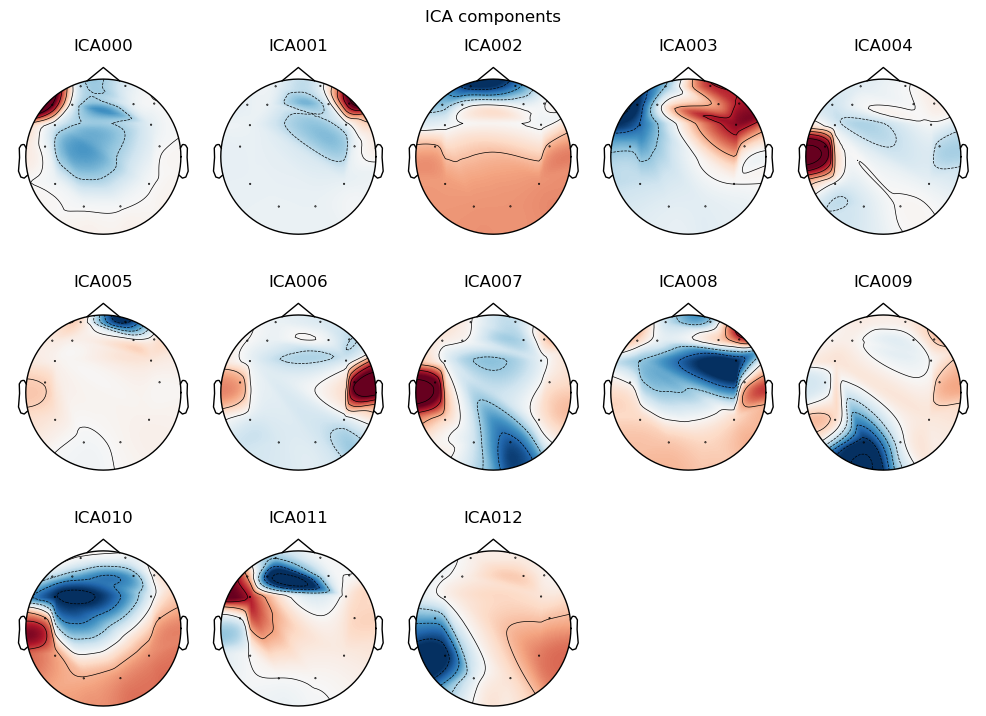

In [17]:

ica = ICA(n_components=None, random_state=42)
ica.fit(raw)

ica.plot_sources(raw)
ica.plot_components()

In [18]:
# ICA 성분 자동 분류
ic_labels = label_components(raw, ica, method='iclabel')

# 뇌파가 아닌 성분들 자동 제거
labels = ic_labels['labels']
exclude_idx = [idx for idx, label in enumerate(labels) 
               if label in ['eye blink', 'muscle artifact', 'heart beat']]

ica.exclude = exclude_idx
ica.apply(raw)
print(f"자동 제거될 성분: {exclude_idx}")

C:\Users\uiseong\AppData\Local\Temp\ipykernel_32752\3239725778.py:2: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\uiseong\AppData\Local\Temp\ipykernel_32752\3239725778.py:2: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(raw, ica, method='iclabel')


Applying ICA to Raw instance
    Transforming to ICA space (13 components)
    Zeroing out 5 ICA components
    Projecting back using 14 PCA components
자동 제거될 성분: [2, 3, 4, 5, 6]


In [19]:
raw.plot()

In [21]:
def load_and_segment_nback_data(raw, marker_file):
    # EEG 데이터 로드
    raw = raw
    
    # Marker 정보 로드
    markers_df = pd.read_csv(marker_file)
    
    # Task 시작과 끝 시간 찾기
    task_starts = markers_df[markers_df['type'] == 'task_start']['latency'].values
    task_ends = markers_df[markers_df['type'] == 'task__end']['latency'].values
    
    # 데이터 세그먼트 저장을 위한 딕셔너리
    segments = {
        '0back': None,
        'rest': [],
        '2back': None,
        '3back': None
    }
    
    # 첫 번째 블록: 0-back
    zero_back_end_idx = np.where(task_starts < task_ends[0])[0][-1]
    segments['0back'] = raw.copy().crop(tmin=task_starts[0], tmax=task_ends[0])
    
    # 첫 번째 rest
    rest_start = task_ends[0]
    rest_end = task_starts[zero_back_end_idx + 1]
    segments['rest'].append(raw.copy().crop(tmin=rest_start, tmax=rest_end))
    
    # 두 번째 블록: 2-back
    two_back_end_idx = np.where(task_starts < task_ends[1])[0][-1]
    segments['2back'] = raw.copy().crop(tmin=task_starts[zero_back_end_idx + 1], tmax=task_ends[1])
    
    # 두 번째 rest
    rest_start = task_ends[1]
    rest_end = task_starts[two_back_end_idx + 1]
    segments['rest'].append(raw.copy().crop(tmin=rest_start, tmax=rest_end))
    
    # 세 번째 블록: 3-back
    three_back_end_idx = np.where(task_starts < task_ends[2])[0][-1]
    segments['3back'] = raw.copy().crop(tmin=task_starts[two_back_end_idx + 1], tmax=task_ends[2])
    
    # 세 번째 rest (3-back 이후)
    rest_start = task_ends[2]
    if len(task_starts) > three_back_end_idx + 1:
        rest_end = task_starts[three_back_end_idx + 1]
    else:
        rest_end = raw.times[-1]  # 데이터의 끝까지
    segments['rest'].append(raw.copy().crop(tmin=rest_start, tmax=rest_end))
    
    return segments

# 사용 예시
marker_file = 'EEG_nback_task/choi_nback_1_intervalMarker.csv'
segments = load_and_segment_nback_data(raw, marker_file)

# 각 세그먼트 확인
for condition, data in segments.items():
    if condition == 'rest':
        print(f"\n{condition} 조건:")
        for i, rest_data in enumerate(data):
            print(f"세그먼트 {i+1}: {rest_data.times[0]:.2f}s - {rest_data.times[-1]:.2f}s")
    else:
        print(f"\n{condition} 조건:")
        if data is not None:
            print(f"시간 구간: {data.times[0]:.2f}s - {data.times[-1]:.2f}s")


0back 조건:
시간 구간: 0.00s - 40.01s

rest 조건:
세그먼트 1: 0.00s - 23.48s
세그먼트 2: 0.00s - 23.50s
세그먼트 3: 0.00s - 21.62s

2back 조건:
시간 구간: 0.00s - 40.02s

3back 조건:
시간 구간: 0.00s - 39.99s


In [24]:

def get_nback_raw_data(edf_file, marker_file):
    from mne.io import RawArray
    
    # 기존 세그먼트 불러오기
    segments = load_and_segment_nback_data(edf_file, marker_file)
    
    # Task 데이터 저장 (0back, 2back, 3back)
    raw_0back = segments['0back']
    raw_2back = segments['2back']
    raw_3back = segments['3back']
    
    # Rest 데이터 각각 저장
    raw_rest_0back = segments['rest'][0]  # 0-back 이후의 rest
    raw_rest_2back = segments['rest'][1]  # 2-back 이후의 rest
    raw_rest_3back = segments['rest'][2]  # 3-back 이후의 rest
    
    return raw_0back, raw_2back, raw_3back, raw_rest_0back, raw_rest_2back, raw_rest_3back

# 사용 예시
marker_file = 'EEG_nback_task/choi_nback_1_intervalMarker.csv'

# 데이터를 변수에 저장
raw_0back, raw_2back, raw_3back, raw_rest_0back, raw_rest_2back, raw_rest_3back = get_nback_raw_data(raw, marker_file)

# 데이터 확인
print("\n각 조건 데이터 정보:")
for name, raw in [
    ('0-back', raw_0back), ('rest after 0-back', raw_rest_0back),
    ('2-back', raw_2back), ('rest after 2-back', raw_rest_2back),
    ('3-back', raw_3back), ('rest after 3-back', raw_rest_3back)
]:
    print(f"\n{name} 데이터:")
    print(f"시간 길이: {raw.times[-1]:.2f}초")
    print(f"채널 수: {len(raw.ch_names)}")



각 조건 데이터 정보:

0-back 데이터:
시간 길이: 40.01초
채널 수: 14

rest after 0-back 데이터:
시간 길이: 23.48초
채널 수: 14

2-back 데이터:
시간 길이: 40.02초
채널 수: 14

rest after 2-back 데이터:
시간 길이: 23.50초
채널 수: 14

3-back 데이터:
시간 길이: 39.99초
채널 수: 14

rest after 3-back 데이터:
시간 길이: 21.62초
채널 수: 14


In [25]:
import matplotlib.pyplot as plt
import numpy as np

def calculate_erds_with_psd(task_raw, rest_raw, fmin, fmax, channels):
    """
    PSD를 이용하여 ERDS 계산
    
    Parameters:
    -----------
    task_raw : Raw task 데이터
    rest_raw : Raw rest 데이터
    fmin, fmax : 관심 주파수 대역
    channels : 분석할 채널 리스트
    
    Returns:
    --------
    erds : ERDS 값 (퍼센트)
    """
    # 채널 선택
    task_data = task_raw.copy().pick(channels)
    rest_data = rest_raw.copy().pick(channels)
    
    # PSD 계산
    task_psd = task_data.compute_psd(fmin=fmin, fmax=fmax, n_fft=1024, n_overlap=512)
    rest_psd = rest_data.compute_psd(fmin=fmin, fmax=fmax, n_fft=1024, n_overlap=512)
    
    # 관심 주파수 대역의 평균 파워 추출
    freq_mask = (task_psd.freqs >= fmin) & (task_psd.freqs <= fmax)
    task_power = task_psd.get_data()[:, freq_mask].mean(axis=1)
    rest_power = rest_psd.get_data()[:, freq_mask].mean(axis=1)
    
    # ERDS 계산: (Rest - Task) / Rest * 100
    erds = (rest_power - task_power) / rest_power * 100
    
    return erds

# 주파수 대역 정의
freq_bands = {
    'theta': (4, 7),
    'alpha': (8, 13)
}

# 채널 그룹 정의
channel_groups = {
    'theta': ['F3', 'F4'],  # 전두엽 채널
    'alpha': ['P7', 'P8']   # 두정엽 채널
}

# 결과를 저장할 딕셔너리 초기화
results = {}
for band in freq_bands.keys():
    results[band] = {}
    for channel in channel_groups[band]:
        results[band][channel] = []

# 각 조건에 대해 ERDS 계산
conditions = [
    (raw_0back, raw_rest_0back, '0-back'),
    (raw_2back, raw_rest_2back, '2-back'),
    (raw_3back, raw_rest_3back, '3-back')
]

conditions_list = ['0-back', '2-back', '3-back']

# 결과 계산 및 저장
for band_name, (fmin, fmax) in freq_bands.items():
    print(f"\n=== {band_name.capitalize()} 밴드 ({fmin}-{fmax} Hz) ===")
    channels = channel_groups[band_name]
    
    for task_raw, rest_raw, condition in conditions:
        erds = calculate_erds_with_psd(task_raw, rest_raw, fmin, fmax, channels)
        
        for ch_idx, channel in enumerate(channels):
            results[band_name][channel].append(erds[ch_idx])
            print(f"{condition}, {channel}: {erds[ch_idx]:.2f}%")

# 시각화
plt.figure(figsize=(15, 10))

# Theta와 Alpha 밴드를 위한 서브플롯 생성
for i, band in enumerate(['theta', 'alpha']):
    plt.subplot(2, 1, i+1)
    
    channels = channel_groups[band]
    x = np.arange(len(conditions_list))
    width = 0.35
    
    # 각 채널에 대한 막대 그래프
    for j, channel in enumerate(channels):
        plt.bar(x + j*width, results[band][channel], width, 
                label=channel, alpha=0.8)
    
    plt.xlabel('Condition')
    plt.ylabel('ERDS (%)')
    plt.title(f'{band.capitalize()} Band ERDS')
    plt.xticks(x + width/2, conditions_list)
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


=== Theta 밴드 (4-7 Hz) ===
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
0-back, F3: -8.26%
0-back, F4: -43.14%
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
2-back, F3: -36.71%
2-back, F4: 10.94%
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
3-back, F3: 30.26%
3-back, F4: 42.56%

=== Alpha 밴드 (8-13 Hz) ===
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
0-back, P7: 49.17%
0-back, P8: 41.79%
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
2-back, P7: 80.36%
2-back, P8: 60.13%
Effective window size : 8.000 (s)
Effective window size : 8.000 (s)
3-back, P7: 80.69%
3-back, P8: 79.26%
